https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

Import libraries

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df.set_index(date_column, inplace=True)
df = df.groupby(date_column).sum().reset_index()

df = df.dropna()
df.rename(columns={date_column: 'ds', target_column: 'y'}, inplace=True)
df['floor'] = 0
dates = df['ds'].values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Tune model

In [ ]:
import numpy as np
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]# Create a list to store MAPE values for each combination
mapes = [] # Use cross validation to evaluate all parameters
for index, params in enumerate(all_params):
    print(f"Running {index+1}/{len(all_params)}")
    # Fit a model using one parameter combination
    m = Prophet(**params, changepoint_range=0.9).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='7 days', period='24 hours', horizon = '24 hours', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

Running 1/40


08:00:06 - cmdstanpy - INFO - Chain [1] start processing
08:00:06 - cmdstanpy - INFO - Chain [1] done processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] done processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] done processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] start processing
08:00:10 - cmdstanpy - INFO - Chain [1] done processing
08:00:10 - cmdstanpy - INFO - Chain [1] done processing
08:00:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:00:10 - cmdstanpy - ERROR - Chain [1] error: err

KeyboardInterrupt: 

08:00:22 - cmdstanpy - INFO - Chain [1] done processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] done processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] done processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] done processing
08:00:22 - cmdstanpy - INFO - Chain [1] done processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] done processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:22 - cmdstanpy - INFO - Chain [1] start processing
08:00:23 - cmdstanpy - INFO - Chain [1] done processing
08:00:23 - cmdstanpy - INFO - Chain [1

In [6]:
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 12, 'seasonality_mode': 'multiplicative'}


In [7]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'], changepoint_range=0.9)# Fit the model on the training dataset
auto_model.fit(train)# Cross validation



17:22:31 - cmdstanpy - INFO - Chain [1] start processing
17:22:33 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
pred = auto_model.predict(test[['ds']])

In [6]:
non_zero = []
 
for i in pred['yhat']:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)
print_evaluation_metrics(non_zero, test['y']-1, train['y']-1)

Evaluation Metrics:
MSE: 1170059211.59
RMSE: 34206.13
MAE: 29829.29
MAPE: 11.39
SMAPE: 12.04
MASE: 4.07


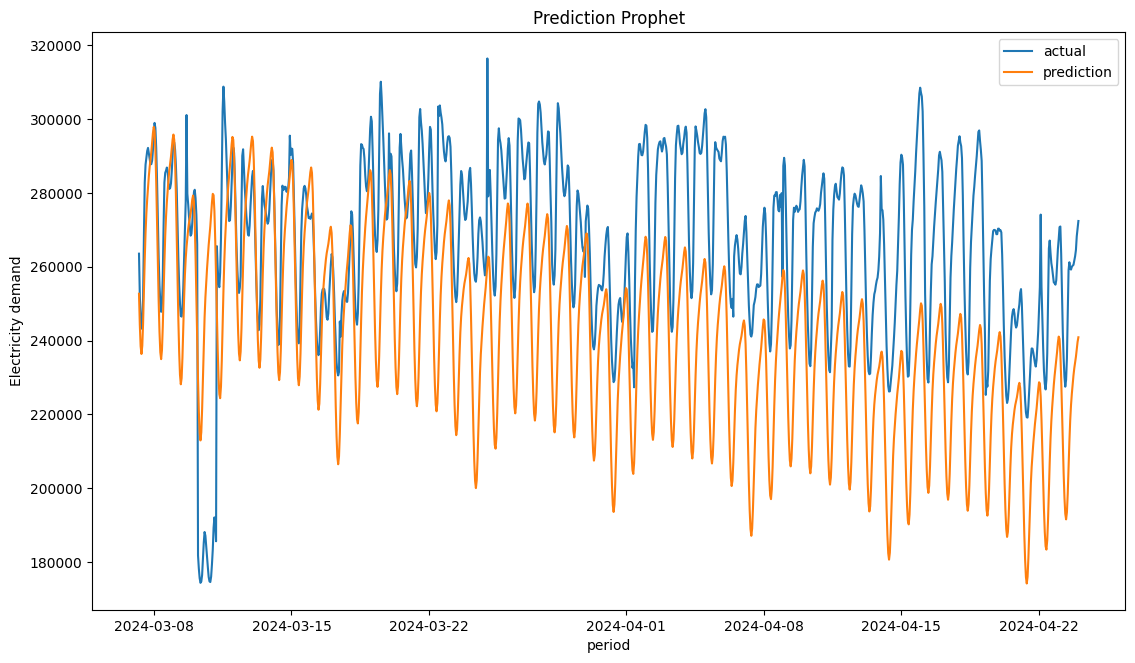

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(pd.to_datetime(test['ds']), (test['y']-1).values, label="actual")
ax.plot(pd.to_datetime(test['ds']), non_zero, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

In [11]:
store_model(auto_model, "prophet")

In [8]:
# Create a copy of the data
data_log = train.copy()# Create the log scale data by taking the natual log of the stock prices.
data_log['y_log'] = np.log(df['y'])
data_log = data_log.drop('y', axis=1).rename(columns={'y_log': 'y'})
data_log.head()

,ds,floor,y
0,2023-01-02 06:00:00,0,12.415665
1,2023-01-02 07:00:00,0,12.389111
2,2023-01-02 08:00:00,0,12.368782
3,2023-01-02 09:00:00,0,12.358004
4,2023-01-02 10:00:00,0,12.360886


In [12]:
# Parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# mapes = []  # Store the MAPEs for each params here# Use cross validation to evaluate all parameters
for index, params in enumerate(all_params):
    print(f"Running {index+1}/{len(all_params)}")
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data_log)
    # Cross-validation
    df_cv = cross_validation(m, initial='7 days', period='24 hours', horizon = '24 hours', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    print(df_p)
    mapes.append(df_p['smape'].values[0])# Tuning results
best_params = all_params[np.argmin(mapes)]# Best parameters
print(best_params)# Train model using best parameters
auto_model_log = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])# Fit the model on the training dataset
auto_model_log.fit(data_log)# Cross validation

Running 5/40


08:01:13 - cmdstanpy - INFO - Chain [1] start processing
08:01:14 - cmdstanpy - INFO - Chain [1] done processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] done processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] done processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] done processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
08:01:17 - cmdstanpy - INFO - Chain [1] done processing
08:01:17 - cmdstanpy - INFO - Chain [1] done processing
08:01:17 - cmdstanpy - INFO - Chain [

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.012473  0.111681  0.078656  0.006269  0.004595  0.006261   

   coverage  
0  0.652449  
Running 6/40


08:03:32 - cmdstanpy - INFO - Chain [1] start processing
08:03:34 - cmdstanpy - INFO - Chain [1] done processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] done processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] done processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] done processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain [1] done processing
08:03:41 - cmdstanpy - INFO - Chain [1] start processing
08:03:41 - cmdstanpy - INFO - Chain 

  horizon       mse      rmse       mae     mape     mdape     smape  coverage
0  1 days  0.012445  0.111558  0.078545  0.00626  0.004617  0.006252  0.650474
Running 7/40


08:05:48 - cmdstanpy - INFO - Chain [1] start processing
08:05:51 - cmdstanpy - INFO - Chain [1] done processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] done processing
08:05:57 - cmdstanpy - INFO - Chain [1] done processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] done processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] done processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain [1] start processing
08:05:57 - cmdstanpy - INFO - Chain 

  horizon      mse      rmse      mae      mape     mdape     smape  coverage
0  1 days  0.01248  0.111712  0.07866  0.006269  0.004622  0.006261  0.650671
Running 8/40


08:08:10 - cmdstanpy - INFO - Chain [1] start processing
08:08:12 - cmdstanpy - INFO - Chain [1] done processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] done processing
08:08:19 - cmdstanpy - INFO - Chain [1] done processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [1] done processing
08:08:19 - cmdstanpy - INFO - Chain [1] done processing
08:08:19 - cmdstanpy - INFO - Chain [1] done processing
08:08:19 - cmdstanpy - INFO - Chain [1] start processing
08:08:19 - cmdstanpy - INFO - Chain [

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0  1 days  0.01243  0.111492  0.078531  0.006259  0.004616  0.006251   0.65156
Running 9/40


08:10:29 - cmdstanpy - INFO - Chain [1] start processing
08:10:32 - cmdstanpy - INFO - Chain [1] done processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] done processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] done processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] done processing
08:10:38 - cmdstanpy - INFO - Chain [1] done processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] start processing
08:10:38 - cmdstanpy - INFO - Chain [1] done processing
08:10:38 - cmdstanpy - INFO - Chain [

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0  1 days  0.012458  0.111618  0.07861  0.006265  0.004623  0.006257  0.651856
Running 10/40


08:12:57 - cmdstanpy - INFO - Chain [1] start processing
08:12:59 - cmdstanpy - INFO - Chain [1] done processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] done processing
08:13:05 - cmdstanpy - INFO - Chain [1] done processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] done processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] done processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] start processing
08:13:05 - cmdstanpy - INFO - Chain [1] done processing
08:13:05 - cmdstanpy - INFO - Chain [

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.012441  0.111538  0.078561  0.006261  0.004615  0.006254   

   coverage  
0  0.651856  
Running 11/40


08:15:21 - cmdstanpy - INFO - Chain [1] start processing
08:15:26 - cmdstanpy - INFO - Chain [1] done processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Chain [1] start processing
08:15:31 - cmdstanpy - INFO - Ch

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011065  0.105192  0.072607  0.005789  0.004203  0.005781   

   coverage  
0  0.651856  
Running 12/40


08:21:23 - cmdstanpy - INFO - Chain [1] start processing
08:21:27 - cmdstanpy - INFO - Chain [1] done processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing
08:21:31 - cmdstanpy - INFO - Ch

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011024  0.104996  0.072382  0.005771  0.004178  0.005763   

   coverage  
0  0.650276  
Running 13/40


08:27:19 - cmdstanpy - INFO - Chain [1] start processing
08:27:24 - cmdstanpy - INFO - Chain [1] done processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] done processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Chain [1] start processing
08:27:28 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011083  0.105277  0.072664  0.005793  0.004202  0.005785   

   coverage  
0  0.651461  
Running 14/40


08:33:29 - cmdstanpy - INFO - Chain [1] start processing
08:33:32 - cmdstanpy - INFO - Chain [1] done processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Chain [1] start processing
08:33:37 - cmdstanpy - INFO - Ch

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0  1 days  0.01105  0.105117  0.072557  0.005785  0.004195  0.005777  0.651066
Running 15/40


08:39:32 - cmdstanpy - INFO - Chain [1] start processing
08:39:35 - cmdstanpy - INFO - Chain [1] done processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Chain [1] start processing
08:39:40 - cmdstanpy - INFO - Ch

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0  1 days  0.011086  0.105291  0.07269  0.005795  0.004217  0.005787  0.651461
Running 16/40


08:45:29 - cmdstanpy - INFO - Chain [1] start processing
08:45:32 - cmdstanpy - INFO - Chain [1] done processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Chain [1] start processing
08:45:37 - cmdstanpy - INFO - Ch

  horizon      mse      rmse      mae      mape     mdape     smape  coverage
0  1 days  0.01104  0.105071  0.07252  0.005782  0.004204  0.005774  0.650474
Running 17/40


08:51:26 - cmdstanpy - INFO - Chain [1] start processing
08:51:31 - cmdstanpy - INFO - Chain [1] done processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:35 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Chain [1] start processing
08:51:36 - cmdstanpy - INFO - Ch

  horizon       mse     rmse       mae      mape     mdape     smape  coverage
0  1 days  0.011075  0.10524  0.072659  0.005793  0.004207  0.005785  0.650671
Running 18/40


08:57:26 - cmdstanpy - INFO - Chain [1] start processing
08:57:29 - cmdstanpy - INFO - Chain [1] done processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] start processing
08:57:34 - cmdstanpy - INFO - Chain [1] done processing
08:57:34 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape   mdape     smape  coverage
0  1 days  0.011055  0.105142  0.072602  0.005788  0.0042  0.005781  0.651165
Running 19/40


09:03:32 - cmdstanpy - INFO - Chain [1] start processing
09:03:35 - cmdstanpy - INFO - Chain [1] done processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Chain [1] start processing
09:03:40 - cmdstanpy - INFO - Ch

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011088  0.105299  0.072691  0.005795  0.004208  0.005787   

   coverage  
0  0.651264  
Running 20/40


09:09:30 - cmdstanpy - INFO - Chain [1] start processing
09:09:33 - cmdstanpy - INFO - Chain [1] done processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] start processing
09:09:37 - cmdstanpy - INFO - Chain [1] done processing
09:09:37 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011055  0.105143  0.072579  0.005787  0.004203  0.005779   

   coverage  
0  0.651659  
Running 21/40


09:15:21 - cmdstanpy - INFO - Chain [1] start processing
09:15:24 - cmdstanpy - INFO - Chain [1] done processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:28 - cmdstanpy - INFO - Chain [1] start processing
09:15:29 - cmdstanpy - INFO - Chain [1] done processing
09:15:29 - cmdstanpy - INFO - Chain [1] done processing
09:15:29 - cmdstanpy - INFO - Chain [1] start processing
09:15:29 - cmdstanpy - INFO - Chai

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011053  0.105133  0.072568  0.005786  0.004213  0.005778   

   coverage  
0  0.649289  
Running 22/40


09:21:31 - cmdstanpy - INFO - Chain [1] start processing
09:21:35 - cmdstanpy - INFO - Chain [1] done processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] start processing
09:21:39 - cmdstanpy - INFO - Chain [1] done processing
09:21:39 - cmdstanpy - INFO - Chain [1] done processing
09:21:39 - cmdstanpy - INFO - Chai

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011019  0.104972  0.072454  0.005777  0.004187  0.005769   

   coverage  
0  0.650276  
Running 23/40


09:27:40 - cmdstanpy - INFO - Chain [1] start processing
09:27:44 - cmdstanpy - INFO - Chain [1] done processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] done processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Chain [1] start processing
09:27:50 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0  1 days  0.011095  0.105331  0.072765  0.005801  0.00423  0.005793  0.648598
Running 24/40


09:33:42 - cmdstanpy - INFO - Chain [1] start processing
09:33:45 - cmdstanpy - INFO - Chain [1] done processing
09:33:50 - cmdstanpy - INFO - Chain [1] start processing
09:33:50 - cmdstanpy - INFO - Chain [1] start processing
09:33:50 - cmdstanpy - INFO - Chain [1] start processing
09:33:50 - cmdstanpy - INFO - Chain [1] start processing
09:33:50 - cmdstanpy - INFO - Chain [1] start processing
09:33:50 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] start processing
09:33:51 - cmdstanpy - INFO - Chain [1] done processing
09:33:51 - cmdstanpy - INFO - Chain [1] done processing
09:33:51 - cmdstanpy - INFO - Chai

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011054  0.105139  0.072652  0.005792  0.004218  0.005784   

   coverage  
0   0.64919  
Running 25/40


09:39:50 - cmdstanpy - INFO - Chain [1] start processing
09:39:53 - cmdstanpy - INFO - Chain [1] done processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:57 - cmdstanpy - INFO - Chain [1] done processing
09:39:57 - cmdstanpy - INFO - Cha

  horizon       mse      rmse      mae      mape     mdape     smape  coverage
0  1 days  0.011101  0.105363  0.07281  0.005805  0.004228  0.005797   0.65077
Running 26/40


09:45:57 - cmdstanpy - INFO - Chain [1] start processing
09:46:01 - cmdstanpy - INFO - Chain [1] done processing
09:46:04 - cmdstanpy - INFO - Chain [1] start processing
09:46:04 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chain [1] done processing
09:46:05 - cmdstanpy - INFO - Chain [1] done processing
09:46:05 - cmdstanpy - INFO - Chain [1] start processing
09:46:05 - cmdstanpy - INFO - Chai

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011057  0.105154  0.072683  0.005795  0.004235  0.005787   

   coverage  
0  0.648598  
Running 27/40


09:52:05 - cmdstanpy - INFO - Chain [1] start processing
09:52:09 - cmdstanpy - INFO - Chain [1] done processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Chain [1] start processing
09:52:13 - cmdstanpy - INFO - Ch

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011108  0.105397  0.072826  0.005806  0.004218  0.005798   

   coverage  
0  0.648795  
Running 28/40


09:58:15 - cmdstanpy - INFO - Chain [1] start processing
09:58:19 - cmdstanpy - INFO - Chain [1] done processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:23 - cmdstanpy - INFO - Chain [1] done processing
09:58:23 - cmdstanpy - INFO - Chain [1] start processing
09:58:24 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011054  0.105138  0.072685  0.005795  0.004236  0.005787   

   coverage  
0    0.6484  
Running 29/40


10:04:28 - cmdstanpy - INFO - Chain [1] start processing
10:04:32 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] done processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chain [1] start processing
10:04:36 - cmdstanpy - INFO - Chai

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011087  0.105297  0.072761  0.005801  0.004236  0.005793   

   coverage  
0  0.648795  
Running 30/40


10:10:38 - cmdstanpy - INFO - Chain [1] start processing
10:10:42 - cmdstanpy - INFO - Chain [1] done processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] done processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] start processing
10:10:46 - cmdstanpy - INFO - Chain [1] done processing
10:10:46 - cmdstanpy - INFO - Chai

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011047  0.105106  0.072634  0.005791  0.004215  0.005783   

   coverage  
0  0.649289  
Running 31/40


10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:49 - cmdstanpy - INFO - Chain [1] done processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing
10:16:53 - cmdstanpy - INFO - Chain [1] done processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain [1] start processing
10:16:53 - cmdstanpy - INFO - Chain

  horizon      mse      rmse       mae      mape     mdape     smape  coverage
0  1 days  0.01124  0.106018  0.073775  0.005881  0.004314  0.005874  0.645241
Running 32/40


10:23:23 - cmdstanpy - INFO - Chain [1] start processing
10:23:27 - cmdstanpy - INFO - Chain [1] done processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Chain [1] done processing
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
10:23:31 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape    mdape     smape  coverage
0  1 days  0.011136  0.105525  0.073212  0.005837  0.00429  0.005829  0.646524
Running 33/40


10:30:01 - cmdstanpy - INFO - Chain [1] start processing
10:30:05 - cmdstanpy - INFO - Chain [1] done processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Chain [1] done processing
10:30:09 - cmdstanpy - INFO - Chain [1] start processing
10:30:09 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape    mdape    smape  coverage
0  1 days  0.011292  0.106265  0.073858  0.005888  0.00433  0.00588  0.644155
Running 34/40


10:36:36 - cmdstanpy - INFO - Chain [1] start processing
10:36:40 - cmdstanpy - INFO - Chain [1] done processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Chain [1] done processing
10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:44 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011228  0.105962  0.073651  0.005872  0.004325  0.005864   

   coverage  
0  0.642575  
Running 35/40


10:43:15 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] done processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011261  0.106116  0.073742  0.005879  0.004315  0.005871   

   coverage  
0  0.646722  
Running 36/40


10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Cha

  horizon      mse      rmse       mae     mape     mdape     smape  coverage
0  1 days  0.01127  0.106162  0.073761  0.00588  0.004315  0.005873  0.645241
Running 37/40


10:56:33 - cmdstanpy - INFO - Chain [1] start processing
10:56:38 - cmdstanpy - INFO - Chain [1] done processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:41 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Chain [1] start processing
10:56:42 - cmdstanpy - INFO - Ch

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011371  0.106636  0.074246  0.005919  0.004346  0.005911   

   coverage  
0  0.642575  
Running 38/40


11:03:08 - cmdstanpy - INFO - Chain [1] start processing
11:03:13 - cmdstanpy - INFO - Chain [1] done processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] done processing
11:03:17 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Cha

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011195  0.105806  0.073467  0.005857  0.004295  0.005849   

   coverage  
0  0.645932  
Running 39/40


11:09:43 - cmdstanpy - INFO - Chain [1] start processing
11:09:47 - cmdstanpy - INFO - Chain [1] done processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] start processing
11:09:51 - cmdstanpy - INFO - Chain [1] done processing
11:09:51 - cmdstanpy - INFO - Chain [1] done processing
11:09:51 - cmdstanpy - INFO - Chai

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011275  0.106185  0.073742  0.005879  0.004296  0.005871   

   coverage  
0  0.645636  
Running 40/40


11:16:23 - cmdstanpy - INFO - Chain [1] start processing
11:16:27 - cmdstanpy - INFO - Chain [1] done processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Ch

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.011216  0.105904  0.073519  0.005861  0.004298  0.005854   

   coverage  
0  0.646327  
{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


11:23:01 - cmdstanpy - INFO - Chain [1] start processing
11:23:05 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
best_params

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 5,
 'seasonality_mode': 'additive'}

In [10]:
pred = auto_model_log.predict(test)
pred = y_pred_original_scale = np.exp(pred['yhat'])


In [11]:
non_zero = []
for i in pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)
print_evaluation_metrics(non_zero, test['y']-1, train['y']-1)

Evaluation Metrics:
MSE: 359007448.74
RMSE: 18947.49
MAE: 12924.33
MAPE: 5.07
SMAPE: 4.95
MASE: 1.76


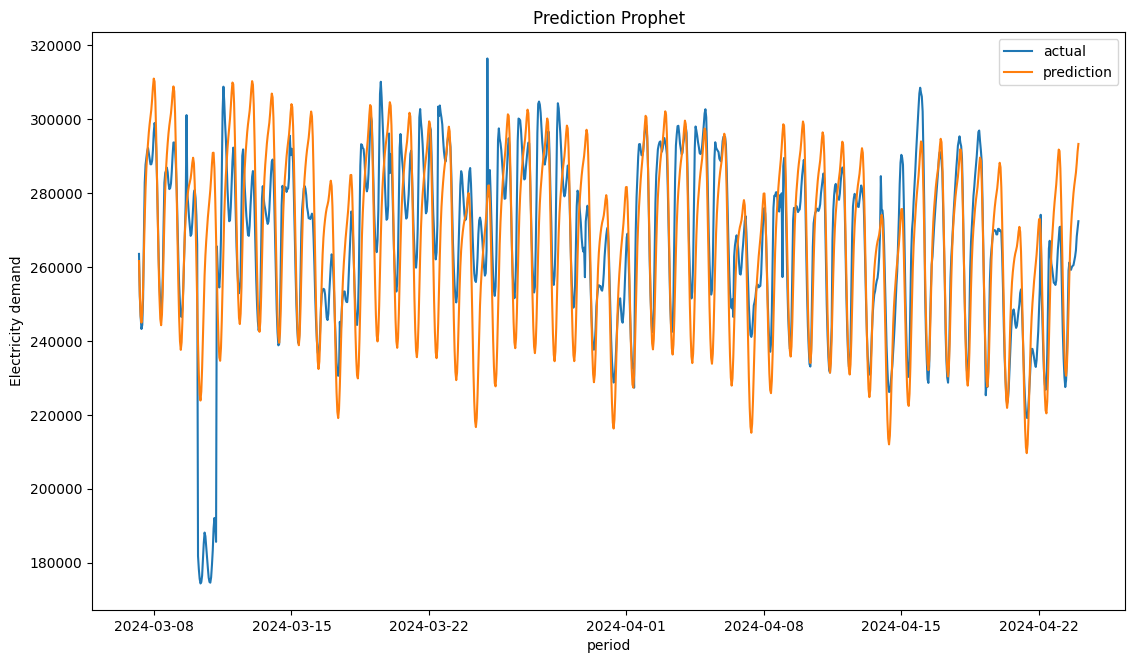

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(pd.to_datetime(test['ds']), (test['y']-1).values, label="actual")
ax.plot(pd.to_datetime(test['ds']), non_zero, label="prediction")
ax.set_title("Prediction Prophet")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [ ]:
store_model(auto_model_log, "prophet_log")